In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scinet import *
import scinet.ed_collision as edc

Instructions for updating:
non-resource variables are not supported in the long term
hi


### Plotting functions

In [10]:
 # Plot the activation of the latent neuron against the total angular momentum. The input data is of the same form as the training/validation data and the corresponding states
def plot_state_neuron_wrt_angular_momentum(nn,data,data_states):
    total_angular_momentum=edc.total_ang_mom(data_states[:,2],data_states[:,5])
    out = nn.run(data, nn.mu, additional_params={})
    f=plt.figure(figsize=(3.4, 2.1))
    blue_color = '#000cff'
    plt.scatter(total_angular_momentum,out.flatten(),1,color=blue_color)
    plt.xlabel('Total angular momentum [kg$\,$m$^2$/s]')
    plt.ylabel('Activation latent neuron')
    return f

# Plot the 2D physical setting for the angular momentum conservation example. The data/data_states is of the same shape as the training or validation data/data_states.
# The situation at the ith data sample is then plotted.
def plot_physical_setting(nn,index,data,data_states):
    vx_in=data_states[index,2]
    w_in=data_states[index,5]
    vx_out=data_states[index,6]
    input1=data[0][index]
    input2=data[1][index]
    # Before the collision
    input1=input1.flatten()
    part=int(input1.size / 6)
    x_in_free=input1[0:part]
    y_in_free = input1[part:2*part]
    x_in_rot = input1[3*part:4*part]
    y_in_rot = input1[4 *part:5*part]
    # After collision
    input2 = input2.flatten()
    part = int((input2.size-1)/3)
    x_out_free = input2[0:part]
    y_out_free = input2[part:2*part]
    # Correct position of rotating particle
    times=np.linspace(0,4, num=4)
    x_out_rot_correct=[]
    y_out_rot_correct=[]
    for i in range(len(times)):
        x_out_rot_correct.append(edc.generate_output(times[i], vx_out, vx_in, w_in)[0])
        y_out_rot_correct.append(edc.generate_output(times[i], vx_out, vx_in, w_in)[1])
    # Predicted  position of rotating particle
    x_out_rot_pred = []
    y_out_rot_pred = []
    data_modified=[data[0].copy(),data[1].copy(),data[2].copy()]
    for i in range(len(times)):
        data_modified[1][index][-1]=times[i]
        output = nn.run(data_modified,nn.output)[index]
        x_out_rot_pred.append(output[0])
        y_out_rot_pred.append(output[1])
    # Create plot
    blue_color = '#000cff'
    orange_color = '#ff7700'
    f = plt.figure()
    ax = plt.subplot(111)
    plt.scatter(x_in_free, y_in_free,15, color=blue_color, marker='o',label='Incoming free particle')
    plt.scatter(x_in_rot, y_in_rot,15, color=orange_color,marker='o', label='Incoming rotating particle')
    plt.scatter(x_out_free,y_out_free,15, color=blue_color, marker='s', label='Outgoing free particle')
    plt.scatter(x_out_rot_correct, y_out_rot_correct,50, color=orange_color, marker='s', label='Outgoing rotating particle')
    plt.scatter(x_out_rot_pred, y_out_rot_pred, color='k', marker='x', label='Pedictions')
    # Shrink current axis by 40%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Collision experiment and predictions of the NN')
    plt.axis([-4,4 , -2, 6])
    return f

## Load pre-trained model

### Parameters
- `latent_size: 1` 
- `input_size: 30`
- `input2_size: 16`
- `output_size: 2`
- `encoder_num_units: [150, 100]`
- `decoder_num_units: [100, 150]`
- other parameters: default values

### Data
-  The masses and the radius of the rotating particle are fixed. The others are varied under the restriction that the two particle will collide at (0,1). See the data generation file ``ed_collision`` for more details. 
- N_in1 = 5 time steps for observation input, N_inp2 = 5 time steps for question input
- training data: 490000 samples
- validation data: 10000 samples

### Training
- `epoch_num: 100`, `batch_size: 500`, `learning_rate: 5e-4`, `beta: 0.`
- `epoch_num: 50`, `batch_size: 500`, `learning_rate: 1e-4`, `beta: 0.`

In [3]:
net = nn.Network.from_saved('collision')

{'decoder_num_units': [100, 150], 'input2_size': 16, 'tot_epochs': 150, 'latent_size': 1, 'output_size': 2, 'encoder_num_units': [150, 100], 'input_size': 30, 'name': 'collision', 'load_file': 'collision'}
INFO:tensorflow:Restoring parameters from /home/elhamod/projects/nn_physical_concepts/tf_save/collision.ckpt
Loaded network from file collision


In [4]:
vd, vs, _ = edc.create_data(50000, 5, 5);

## Plots

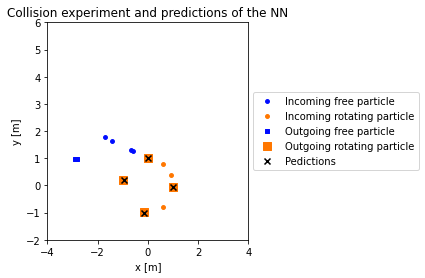

In [11]:
fig1 = plot_physical_setting(net, 0, vd, vs)

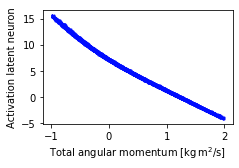

In [12]:
fig2 = plot_state_neuron_wrt_angular_momentum(net, vd, vs)

## Calculate reconstruction loss

In [13]:
np.sqrt(net.run(vd, net.recon_loss))

0.039321594